![tracker](https://us-central1-vertex-ai-mlops-369716.cloudfunctions.net/pixel-tracking?path=statmike%2Fvertex-ai-mlops%2FApplied+GenAI%2FEmbeddings&file=Vertex+AI+Text+Embeddings+API.ipynb)
<!--- header table --->
<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/statmike/vertex-ai-mlops/blob/main/Applied%20GenAI/Embeddings/Vertex%20AI%20Text%20Embeddings%20API.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Google Colaboratory logo">
      <br>Run in<br>Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https%3A%2F%2Fraw.githubusercontent.com%2Fstatmike%2Fvertex-ai-mlops%2Fmain%2FApplied%2520GenAI%2FEmbeddings%2FVertex%2520AI%2520Text%2520Embeddings%2520API.ipynb">
      <img width="32px" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" alt="Google Cloud Colab Enterprise logo">
      <br>Run in<br>Colab Enterprise
    </a>
  </td>      
  <td style="text-align: center">
    <a href="https://github.com/statmike/vertex-ai-mlops/blob/main/Applied%20GenAI/Embeddings/Vertex%20AI%20Text%20Embeddings%20API.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      <br>View on<br>GitHub
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/statmike/vertex-ai-mlops/main/Applied%20GenAI/Embeddings/Vertex%20AI%20Text%20Embeddings%20API.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
      <br>Open in<br>Vertex AI Workbench
    </a>
  </td>
</table>

# Vertex AI Text Embeddings API

Embeddings are condensed representations of data that retain the information from the data.  They are represented by a vector of numbers, usually floats, like `[0, 1, 0, 1]` or `[0.63475, 0.234, ..., 0.2646]`.  They are a trained/learned representation for data like text, images, and tables and served as preditions form these models. Based on the type of model that is used in training they can be very good at retaining latent information like semantic meaning in text, objects in images, and correlation in tables.

[Vertex AI APIs for embeddings](https://cloud.google.com/vertex-ai/generative-ai/docs/embeddings) provide simplified access to [Google's embedding models](https://cloud.google.com/vertex-ai/generative-ai/docs/learn/models#models) hosted on Vertex AI.

This workflow will show how to interact with the API for single, multiple, and large volumes of requests for **text embeddings**.

**References:**
- [Get text embeddings](https://cloud.google.com/vertex-ai/generative-ai/docs/embeddings/get-text-embeddings)
- [Text embeddings API](https://cloud.google.com/vertex-ai/generative-ai/docs/model-reference/text-embeddings-api)

Ready to use text embeddings in your applications?  Read more about [embeddings in this repository](./readme.md), including an overview of math with embeddings used for similarity: [The Math of Similarity](./The%20Math%20of%20Similarity.ipynb)

---
## Colab Setup

To run this notebook in Colab run the cells in this section.  Otherwise, skip this section.

This cell will authenticate to GCP (follow prompts in the popup).

In [1]:
PROJECT_ID = 'statmike-mlops-349915' # replace with project ID

In [1]:
try:
    from google.colab import auth
    auth.authenticate_user()
    !gcloud config set project {PROJECT_ID}
    print('Colab authorized to GCP')
except Exception:
    print('Not a Colab Environment')
    pass

Not a Colab Environment


---
## Installs

The list `packages` contains tuples of package import names and install names.  If the import name is not found then the install name is used to install quitely for the current user.

In [2]:
# tuples of (import name, install name, min_version)
packages = [
    ('google.cloud.aiplatform', 'google-cloud-aiplatform', '1.66.0'),
    ('google.cloud.storage', 'google-cloud-storage'),
    ('google.cloud.bigquery', 'google-cloud-bigquery'),
    ('numpy', 'numpy')
]

import importlib
install = False
for package in packages:
    if not importlib.util.find_spec(package[0]):
        print(f'installing package {package[1]}')
        install = True
        !pip install {package[1]} -U -q --user
    elif len(package) == 3:
        if importlib.metadata.version(package[0]) < package[2]:
            print(f'updating package {package[1]}')
            install = True
            !pip install {package[1]} -U -q --user

### API Enablement

In [3]:
!gcloud services enable aiplatform.googleapis.com

### Restart Kernel (If Installs Occured)

After a kernel restart the code submission can start with the next cell after this one.

In [4]:
if install:
    import IPython
    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)
    IPython.display.display(IPython.display.Markdown("""<div class=\"alert alert-block alert-warning\">
        <b>⚠️ The kernel is going to restart. Please wait until it is finished before continuing to the next step. The previous cells do not need to be run again⚠️</b>
        </div>"""))

---
## Setup

inputs:

In [5]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'statmike-mlops-349915'

In [6]:
REGION = 'us-central1'
SERIES = 'applied-genai'
EXPERIMENT = 'embeddings-api'

# Set the BUCKET name for saving work:
BUCKET = PROJECT_ID

# Set BigQuery Names
BQ_PROJECT = PROJECT_ID
BQ_DATASET = SERIES.replace('-', '_')
BQ_TABLE = EXPERIMENT
BQ_REGION = REGION[0:2] # pick a multi-region

packages:

In [50]:
import os, shutil, glob
import asyncio
import json
import matplotlib.pyplot as plt
import numpy as np

from google.cloud import aiplatform
from google.cloud import bigquery
from google.cloud import storage
import vertexai.language_models # for text embedding models

In [8]:
aiplatform.__version__

'1.69.0'

clients:

In [9]:
vertexai.init(project = PROJECT_ID, location = REGION)
gcs = storage.Client(project = PROJECT_ID)
bq = bigquery.Client(project = PROJECT_ID)

bucket = gcs.lookup_bucket(BUCKET)

Parameters:

In [10]:
DIR = f"files/{EXPERIMENT}"

Environment:

In [11]:
if not os.path.exists(DIR):
    os.makedirs(DIR)

---
## Text For Examples

This repository contains a [section for document processing (chunking)](../Chunking/readme.md) that includes an [example of processing a PDF with the Document AI Layout Parser](../Chunking/Process%20Documents%20-%20Document%20AI%20Layout%20Parser.ipynb).  The chunks of text from that workflow are stored with this repository and loaded for use in this example.  The following code will load the text from the local drive and if it is missing it will first download it from the repository on GitHub.

### Get The Documents

If you are working from a clone of this notebooks [repository](https://github.com/statmike/vertex-ai-mlops) then the documents are already present. The following cell checks for the documents folder and if it is missing gets it (`git clone`):

In [12]:
local_dir = '../Chunking/files'

In [13]:
if not os.path.exists(local_dir):
    print('Retrieving documents...')
    parent_dir = os.path.dirname(local_dir)
    temp_dir = os.path.join(parent_dir, 'temp')
    if not os.path.exists(temp_dir):
        os.makedirs(temp_dir)
    !git clone https://www.github.com/statmike/vertex-ai-mlops {temp_dir}/vertex-ai-mlops
    shutil.copytree(f'{temp_dir}/vertex-ai-mlops/Applied GenAI/Generate/files/imagen', local_dir)
    shutil.rmtree(temp_dir)
    print(f'Documents are now in folder `{local_dir}`')
else:
    print(f'Documents Found in folder `{local_dir}`')             

Documents Found in folder `../Chunking/files`


### Load The Chunks

In [14]:
with open('../Chunking/files/layout-parser/document-chunks.jsonl', 'r') as f:
    chunks = [json.loads(line) for line in f]

### Review A Chunk

In [15]:
chunks[0]

{'chunk_id': 'c1',
 'content': '# OFFICIAL BASEBALL RULES\n\n2023 Edition TM TM',
 'page_span': {'page_start': 1, 'page_end': 7},
 'page_footers': [{'text': 'V1',
   'page_span': {'page_start': 6, 'page_end': 6}},
  {'text': 'vii', 'page_span': {'page_start': 7, 'page_end': 7}}],
 'source_block_ids': [],
 'page_headers': []}

---
## Select And Setup Embedding Model

Select one of the [supported text embedding models](https://cloud.google.com/vertex-ai/generative-ai/docs/embeddings/get-text-embeddings#supported-models).  In this case `text-embedding-004` is used.

In [51]:
embedder = vertexai.language_models.TextEmbeddingModel.from_pretrained('text-embedding-004')

---
## Embedding Requests

### Single Instance

In [61]:
response = embedder.get_embeddings([chunks[0]['content']])

In [62]:
len(response)

1

In [63]:
response[0].values[0:10]

[-0.0014270133106037974,
 0.0252088475972414,
 -5.299176336848177e-05,
 -0.043303824961185455,
 -0.02709619142115116,
 0.004390457645058632,
 0.06190471723675728,
 0.053955815732479095,
 0.008000040426850319,
 -0.05304357036948204]

In [64]:
len(response[0].values)

768

In [65]:
response[0].statistics

TextEmbeddingStatistics(token_count=19.0, truncated=False)

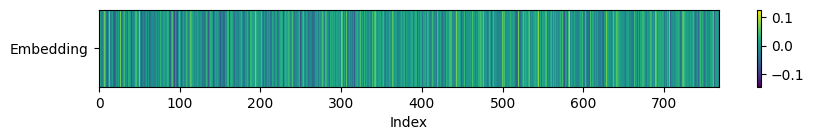

In [66]:
plt.figure(figsize=(10, 1))
plt.imshow([response[0].values], cmap='viridis', aspect='auto')
plt.xlabel('Index')
plt.yticks([0], ["Embedding"]) 
plt.colorbar()
plt.show()

---
### Multiple Instances, Single Request

A single request can contain up to 250 instances in `us-central1`.  [More Details](https://cloud.google.com/vertex-ai/generative-ai/docs/quotas#text-embedding-limits)

In [96]:
n_instances = 10

In [97]:
response = embedder.get_embeddings([chunks[i]['content'] for i in range(n_instances)])

In [98]:
len(response)

10

In [99]:
response[0].values[0:10]

[-0.0014270133106037974,
 0.0252088475972414,
 -5.299176336848177e-05,
 -0.043303824961185455,
 -0.02709619142115116,
 0.004390457645058632,
 0.06190471723675728,
 0.053955815732479095,
 0.008000040426850319,
 -0.05304357036948204]

In [100]:
response[-1].values[0:10]

[0.012910179793834686,
 0.02096092514693737,
 -0.011132142506539822,
 0.018320411443710327,
 -0.028627533465623856,
 0.01824655383825302,
 0.065038301050663,
 0.05292586237192154,
 0.02120327204465866,
 -0.028758231550455093]

In [101]:
len(response[0].values)

768

In [102]:
len(response[-1].values)

768

In [103]:
response[0].statistics

TextEmbeddingStatistics(token_count=19.0, truncated=False)

In [104]:
response[-1].statistics

TextEmbeddingStatistics(token_count=119.0, truncated=False)

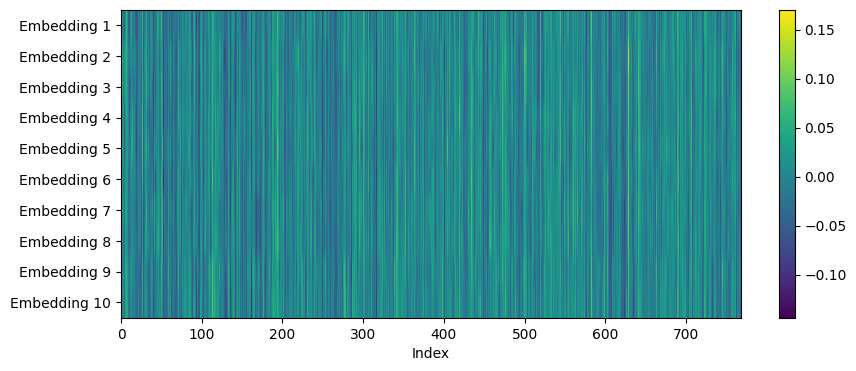

In [107]:
plt.figure(figsize=(10, 4))
plt.imshow([r.values for r in response], cmap='viridis', aspect='auto')
plt.xlabel('Index')
plt.yticks(list(range(n_instances)), [f"Embedding {i+1}" for i in range(n_instances)]) 
plt.colorbar()
plt.show()

---
### Async Request: Single

In [167]:
response = await embedder.get_embeddings_async([chunks[0]['content']])

In [169]:
len(response)

1

In [170]:
response[0].values[0:10]

[-0.0014270133106037974,
 0.0252088475972414,
 -5.299176336848177e-05,
 -0.043303824961185455,
 -0.02709619142115116,
 0.004390457645058632,
 0.06190471723675728,
 0.053955815732479095,
 0.008000040426850319,
 -0.05304357036948204]

In [171]:
len(response[0].values)

768

In [172]:
response[0].statistics

TextEmbeddingStatistics(token_count=19.0, truncated=False)

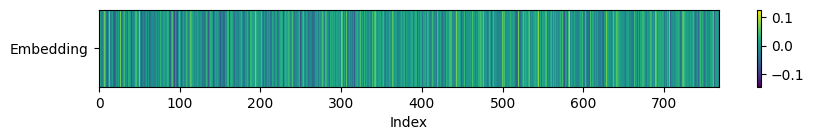

In [173]:
plt.figure(figsize=(10, 1))
plt.imshow([response[0].values], cmap='viridis', aspect='auto')
plt.xlabel('Index')
plt.yticks([0], ["Embedding"]) 
plt.colorbar()
plt.show()

---
### Async Requests: Many

An advantage to asynchronous request is that they can be run simoutaneously.  There are limits on the API for the number of request per minute that might lead to error where you need to implement retries backoff methods.

For embedding in `us-central1` the default limit per minute is 1500.  [More details here](https://cloud.google.com/vertex-ai/generative-ai/docs/quotas#rate-limits)

In [175]:
response = await asyncio.gather(*[
    embedder.get_embeddings_async([chunks[i]['content']]) for i in range(len(chunks))
])

In [177]:
len(response)

867

In [180]:
response[0][0].values[0:10]

[-0.0014270133106037974,
 0.0252088475972414,
 -5.299176336848177e-05,
 -0.043303824961185455,
 -0.02709619142115116,
 0.004390457645058632,
 0.06190471723675728,
 0.053955815732479095,
 0.008000040426850319,
 -0.05304357036948204]

In [181]:
response[-1][0].values[0:10]

[0.02161160483956337,
 0.038336873054504395,
 -0.020024865865707397,
 0.010516938753426075,
 -0.012892897240817547,
 -0.014998161233961582,
 0.013282003812491894,
 0.037676580250263214,
 -0.026520458981394768,
 0.019920088350772858]

In [182]:
len(response[0][0].values)

768

In [183]:
len(response[-1][0].values)

768

In [184]:
response[0][0].statistics

TextEmbeddingStatistics(token_count=19.0, truncated=False)

In [185]:
response[-1][0].statistics

TextEmbeddingStatistics(token_count=148.0, truncated=False)

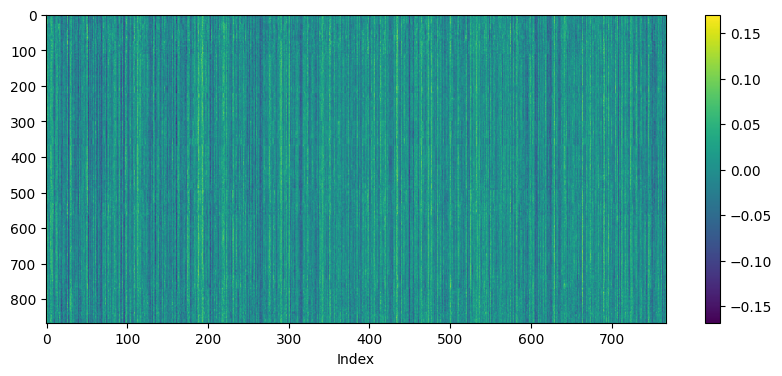

In [187]:
plt.figure(figsize=(10, 4))
plt.imshow([r[0].values for r in response], cmap='viridis', aspect='auto')
plt.xlabel('Index')
#plt.yticks(list(range(len(response))), [f"Embedding {i+1}" for i in range(len(response))]) 
plt.colorbar()
plt.show()

---
## Embeddings For Different Tasks

The Verttex AI embeddings models can be [optimized for different task types](https://cloud.google.com/vertex-ai/generative-ai/docs/embeddings/task-types).  For instance, the default is `RETRIEVAL_QUERY` which is optimized for general matching and retrieval.  These are specific task types that can be specified:
- `SEMANTIC_SIMILARITY`  is optimized for  assessing text similarity 
- `CLASSIFICATION`  is optimized for classifying text with preset lables
- `CLUSTERING`  is optimized for clustering text based on similarity
- `RETRIEVAL_DOCUMENT`  is optimized for document search
- `RETRIEVAL_QUERY`  is optimzied for information retrieval (default)
- `QUESTION_ANSWERING`  is optimzied for question answering where the query is a proper question with a "?"
- `FACT_VERIFICATION`  is optimized for fact verification queries
- `CODE_RETRIEVAL_TASK` is optimized to find relevant code blocks
    - at first this is only for model text-embedding-preview-0815`

In [223]:
task_types = [
    'SEMANTIC_SIMILARITY', 
    'CLASSIFICATION',
    'CLUSTERING',
    'RETRIEVAL_DOCUMENT',
    'RETRIEVAL_QUERY',
    'QUESTION_ANSWERING',
    'FACT_VERIFICATION'
]

Try all task types for example chunk:

In [224]:
task_responses = embedder.get_embeddings(
    [vertexai.language_models.TextEmbeddingInput(chunks[0]['content'], task) for task in task_types]
)

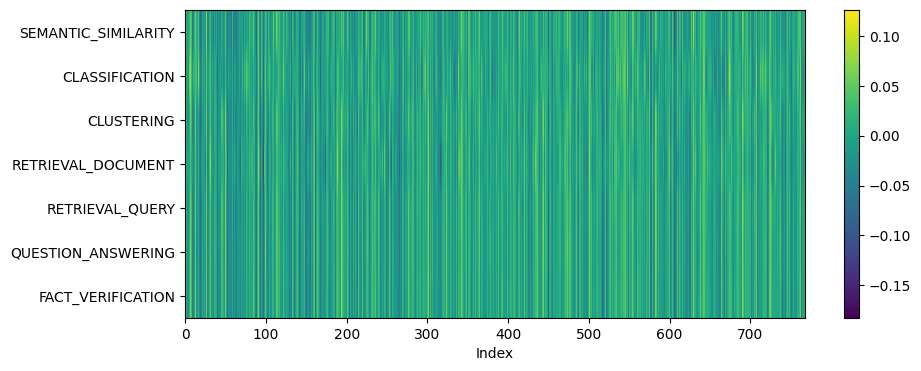

In [225]:
plt.figure(figsize=(10, 4))
plt.imshow([r.values for r in task_responses], cmap='viridis', aspect='auto')
plt.xlabel('Index')
plt.yticks(list(range(len(task_responses))), task_types) 
plt.colorbar()
plt.show()

---
## Embeddings Dimension Size

The default dimension size of embeddings from the api is 768 as seen in all the examples above.  The dimension can be configured to any integer value from 1 to 768.  This example shows a range of dimension sizes from a single request (as an example).

Why would a smaller embedding be helpful?  Efficiency in storage size and lower latency in usage.  A lower dimensionn can lead to a lower accuracy for the tasks you are using embeddings for - like semantic similarity matching.

Each request can set the `output_dimensionality` parameter to the desired dimension size.  The example below leverages async calls to get a range (all possible) of different dimensions.

In [226]:
dim_size_responses = await asyncio.gather(*[
    embedder.get_embeddings_async([chunks[0]['content']], output_dimensionality = d+1)
    for d in range(768)
])

In [227]:
len(dim_size_responses)

768

In [228]:
dim_size_responses[0][0].values

[-0.0014270133106037974]

In [229]:
dim_size_responses[1][0].values

[-0.0014270133106037974, 0.0252088475972414]

In [230]:
dim_size_responses[2][0].values

[-0.0014270133106037974, 0.0252088475972414, -5.299176336848177e-05]

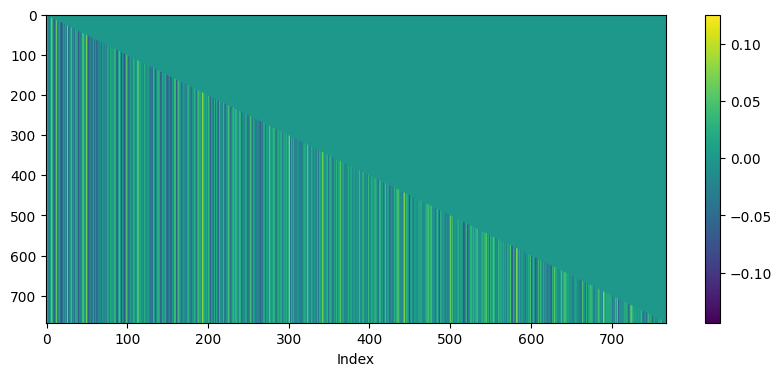

In [231]:
plt.figure(figsize=(10, 4))
plt.imshow([r[0].values +[0]*(768 - len(r[0].values)) for r in dim_size_responses], cmap='viridis', aspect='auto')
plt.xlabel('Index') 
plt.colorbar()
plt.show()

---
## Embeddings And Normalization

In vector retrieval it can be helpful to normalize embeddings to simplify the math of retrieval.  Read all about this in the workflow [The Math of Similarity](./The%20Math%20of%20Similarity.ipynb).

Vector norms measure the magnitude.  Dividing a vector by its magnitude has this math:
> note that a normalized vector is indicated by giving it a hat: $\hat{a}$

$$
\hat{a} = \frac{a}{||a||_2}
$$

The short answer is the the api is returning normalized embeddings.  Some slight differences might occur due to floating point precision.

### How to Check For Normalization

Get a single embedding:

In [234]:
response = embedder.get_embeddings([chunks[0]['content']])

Convert the embedding from Python list to Numpy array for the calcuations:

In [237]:
embedding = np.array(response[0].values)

Verify the embedding is the expected dimension of 768:

In [250]:
embedding.shape

(768,)

If the embedding is already normalized then it would have magnitude 1.  Here the L2 norm is calculated and show that it is essentially 1 with some error in the 6th decimal place:

In [252]:
np.linalg.norm(embedding, 2)

0.9999985004805458

Create the normalized embedding by dividng the embedding by its magnitude (calculated as the L2 norm):

In [241]:
embedding_normalized = embedding / np.linalg.norm(embedding, 2)

Compare the first few element of the embedding to the normalized embedding.  Notice they are nearly identical:

In [242]:
embedding[0:10]

array([-1.42701331e-03,  2.52088476e-02, -5.29917634e-05, -4.33038250e-02,
       -2.70961914e-02,  4.39045765e-03,  6.19047172e-02,  5.39558157e-02,
        8.00004043e-03, -5.30435704e-02])

In [243]:
embedding_normalized[0:10]

array([-1.42701545e-03,  2.52088854e-02, -5.29918428e-05, -4.33038899e-02,
       -2.70962321e-02,  4.39046423e-03,  6.19048101e-02,  5.39558966e-02,
        8.00005242e-03, -5.30436499e-02])

Visualize the difference between the embedding and normalized embedding:

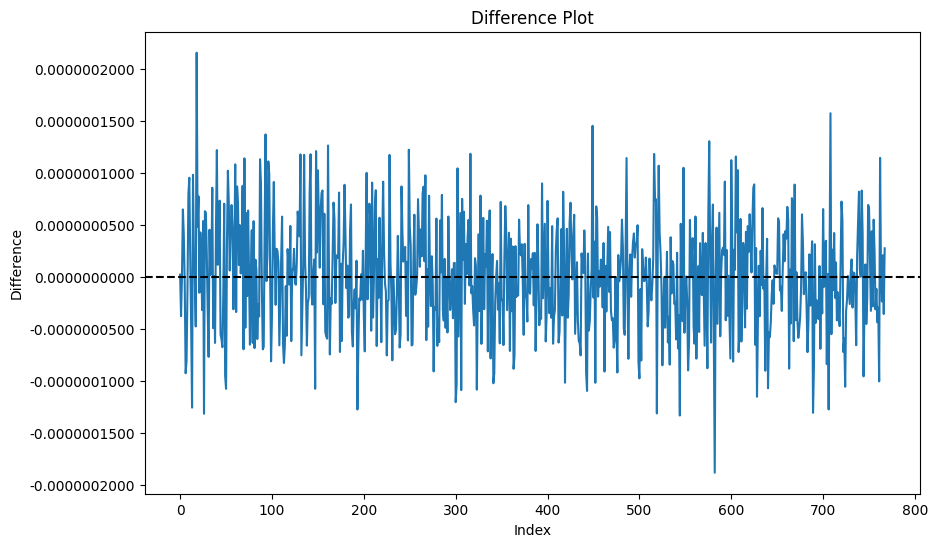

In [255]:
import matplotlib.ticker as ticker
plt.figure(figsize=(10, 6))
plt.plot(embedding - embedding_normalized)
plt.xlabel('Index')
plt.ylabel('Difference')
plt.title('Difference Plot')
plt.axhline(y=0, color='k', linestyle='--')  # Add a zero line
plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('%.10f'))
plt.show()

Calcualate the largest difference between the api response and the normalized version of the response:

In [257]:
max_diff = np.max(np.abs(embedding - embedding_normalized))
print(f"The maximum absolute difference is: {max_diff:.10f}")

The maximum absolute difference is: 0.0000002158


**Notice** that the largest difference is just a floating point difference with error in the 7th decimal place.

### Checking Embeddings From Different Task Optimziations

What is the magnitude, norm, for each task type?

In [260]:
for t, task in enumerate(task_responses):
    print(f"The norm for the {task_types[t]} task type is {np.linalg.norm(np.array(task.values), 2)}")

The norm for the SEMANTIC_SIMILARITY task type is 0.9999987713022724
The norm for the CLASSIFICATION task type is 0.9999980236817011
The norm for the CLUSTERING task type is 0.9999985004805458
The norm for the RETRIEVAL_DOCUMENT task type is 0.9999993640838604
The norm for the RETRIEVAL_QUERY task type is 0.9999985004805458
The norm for the QUESTION_ANSWERING task type is 0.9999985168306245
The norm for the FACT_VERIFICATION task type is 0.9999984910619315


### Checking Embedding Of Different Dimensions

Since the request for different dimension size returns a truncated list of the embedding for smaller dimensions the magnitudes are <1 for each dimension < 768.

In [263]:
dim_norms = [np.linalg.norm(np.array(r[0].values), 2) for r in dim_size_responses]
dim_sizes = range(1, len(dim_norms) + 1)

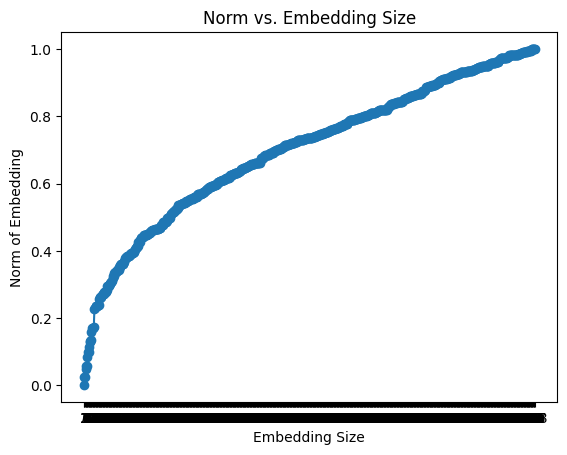

In [265]:
plt.plot(dim_sizes, dim_norms, marker='o')
plt.xlabel('Embedding Size')
plt.ylabel('Norm of Embedding')
plt.title('Norm vs. Embedding Size')
plt.xticks(dim_sizes)  # Show integer ticks on the x-axis
#plt.grid(True)
plt.show()

---
## Batch Embeddings

For non-latency sensitive requests the batch method is more effective for large numbers of embeddings.  

The online requests above showed how to request single and multiple instances.  With batch request the instances need to be separated and prepared as either JSONL files stored in GCS, or in BigQuery tables.  Both of theses methods are shown below.

A single request can have up to 30,000 instances (prompts).  The defautl qouta is up to 4 concurrent batch prediction jobs for `textembedding_gecko`. [More Details](https://cloud.google.com/vertex-ai/generative-ai/docs/quotas#concurrent-batch-requests)

---
### JSONL On GCS

#### Review The Data Locally

In [115]:
len(chunks)

867

In [116]:
chunks[0]

{'chunk_id': 'c1',
 'content': '# OFFICIAL BASEBALL RULES\n\n2023 Edition TM TM',
 'page_span': {'page_start': 1, 'page_end': 7},
 'page_footers': [{'text': 'V1',
   'page_span': {'page_start': 6, 'page_end': 6}},
  {'text': 'vii', 'page_span': {'page_start': 7, 'page_end': 7}}],
 'source_block_ids': [],
 'page_headers': []}

#### Prepare Input And Save To GCS

The JSONL need to have a field named `content` with the text to be embedded.  This is already present in the chunks.

In [114]:
blob = bucket.blob(f'{SERIES}/{EXPERIMENT}/input.jsonl')
jsonl_data = '\n'.join(json.dumps(chunk) for chunk in chunks)
blob.upload_from_string(jsonl_data, content_type = 'application/jsonl')
list(bucket.list_blobs(prefix = f"{SERIES}/{EXPERIMENT}"))

[<Blob: statmike-mlops-349915, applied-genai/embeddings-api/input.jsonl, 1726765490355007>]

#### Embedding Model

The `embedder` object above is already an import of an embedding model.  The batch predictions capability is current in the preview module and is loaded in this step.  In the near future this should able to bypass.

In [123]:
from vertexai.preview import language_models
batch_embedder = language_models.TextEmbeddingModel.from_pretrained('text-embedding-004')

In [27]:
batch_embedder = vertexai.language_models.TextEmbeddingModel.from_pretrained('text-embedding-004')

#### Create Batch Embeddings Job

In [124]:
batch_gcs_job = batch_embedder.batch_predict(
    dataset = [f"gs://{bucket.name}/{blob.name}"],
    destination_uri_prefix = f"gs://{bucket.name}/{SERIES}/{EXPERIMENT}"
)

Creating BatchPredictionJob
BatchPredictionJob created. Resource name: projects/1026793852137/locations/us-central1/batchPredictionJobs/823904847701999616
To use this BatchPredictionJob in another session:
bpj = aiplatform.BatchPredictionJob('projects/1026793852137/locations/us-central1/batchPredictionJobs/823904847701999616')
View Batch Prediction Job:
https://console.cloud.google.com/ai/platform/locations/us-central1/batch-predictions/823904847701999616?project=1026793852137
BatchPredictionJob projects/1026793852137/locations/us-central1/batchPredictionJobs/823904847701999616 current state:
JobState.JOB_STATE_QUEUED
BatchPredictionJob projects/1026793852137/locations/us-central1/batchPredictionJobs/823904847701999616 current state:
JobState.JOB_STATE_QUEUED
BatchPredictionJob projects/1026793852137/locations/us-central1/batchPredictionJobs/823904847701999616 current state:
JobState.JOB_STATE_SUCCEEDED
BatchPredictionJob run completed. Resource name: projects/1026793852137/locations/u

The job object is of type [aiplatform.jobs.BatchPredictionJob](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.BatchPredictionJob)

In [132]:
type(batch_gcs_job)

google.cloud.aiplatform.jobs.BatchPredictionJob

Wait on the job to finish:

In [130]:
batch_gcs_job.state

<JobState.JOB_STATE_SUCCEEDED: 4>

In [135]:
batch_gcs_job.output_info.gcs_output_directory

'gs://statmike-mlops-349915/applied-genai/embeddings-api/prediction-model-2024-09-19T17:15:35.710392Z'

In [139]:
path = '/'.join(batch_gcs_job.output_info.gcs_output_directory.split("/")[3:])

In [140]:
list(bucket.list_blobs(prefix = path))

[<Blob: statmike-mlops-349915, applied-genai/embeddings-api/prediction-model-2024-09-19T17:15:35.710392Z/000000000000.jsonl, 1726766163377424>]

#### Retrieve Batch Predictions

In [142]:
batch_gcs_predictions = []
for blob in list(bucket.list_blobs(prefix = path)):
    jsonl_preds = blob.download_as_string().decode('utf-8')
    jsonl_preds = [json.loads(line) for line in jsonl_preds.splitlines()]
    batch_gcs_predictions += jsonl_preds

In [143]:
len(batch_gcs_predictions)

867

In [146]:
batch_gcs_predictions[0]['instance']

{'page_headers': [],
 'source_block_ids': [],
 'page_span': {'page_end': '3', 'page_start': '2'},
 'page_footers': [],
 'content': '# OFFICIAL BASEBALL RULES\n\n## Official Baseball Rules 2023 Edition\n\n### JOINT COMPETITION COMMITTEE\n\n|-|-|-|\n| Bill DeWitt | Whit Merrifield | Austin Slater |\n| Jack Flaherty | Bill Miller | John Stanton, Chair |\n| Tyler Glasnow | Dick Monfort | Tom Werner |\n| Greg Johnson | Mark Shapiro |  |\n\nCommittee Secretary Paul V. Mifsud, Jr. Copyright © 2023 by the Office of the Commissioner of Baseball',
 'chunk_id': 'c2'}

In [149]:
batch_gcs_predictions[0]['predictions'][0]['embeddings']['statistics']

{'token_count': 125, 'truncated': False}

In [150]:
batch_gcs_predictions[0]['predictions'][0]['embeddings']['values'][0:10]

[0.008681542240083218,
 0.06999468058347702,
 0.003673204220831394,
 0.019888797774910927,
 0.016285404562950134,
 0.035664502531290054,
 0.06200747936964035,
 0.05597030743956566,
 0.0034793149679899216,
 -0.024485772475600243]

#### Process And Store Chunks With Embeddings

This section store the chunks with embeddings as JSONL in this repository.

In [275]:
with open(f'{DIR}/chunk-embeddings.jsonl', 'w') as f:
    for chunk in batch_gcs_predictions:
        f.write(json.dumps(chunk)+ '\n')

In [276]:
os.listdir(DIR)

['chunk-embeddings.jsonl']

---
### JSONL On GCS - For A Larger Set of Chunks

In the **[Large Document Processing - Document AI Layout Parser](../Chunking/Large%20Document%20Processing%20-%20Document%20AI%20Layout%20Parser.ipynb)** workflow, a large set of chunks was created form multiple large pdfs (over 1000 pages each).  Batch text embeddings is a great solution for this volume of embeddings requests.

#### Load Another Set of Chunks (larger)

In [52]:
chunk_dir = '../Chunking/files/layout-parser-large-files'

In [63]:
jsonl_files = glob.glob(f"{chunk_dir}/*.jsonl")
jsonl_files.sort()
jsonl_files

['../Chunking/files/layout-parser-large-files/document-chunks-0000.jsonl',
 '../Chunking/files/layout-parser-large-files/document-chunks-0001.jsonl',
 '../Chunking/files/layout-parser-large-files/document-chunks-0002.jsonl',
 '../Chunking/files/layout-parser-large-files/document-chunks-0003.jsonl',
 '../Chunking/files/layout-parser-large-files/document-chunks-0004.jsonl',
 '../Chunking/files/layout-parser-large-files/document-chunks-0005.jsonl',
 '../Chunking/files/layout-parser-large-files/document-chunks-0006.jsonl',
 '../Chunking/files/layout-parser-large-files/document-chunks-0007.jsonl',
 '../Chunking/files/layout-parser-large-files/document-chunks-0008.jsonl',
 '../Chunking/files/layout-parser-large-files/document-chunks-0009.jsonl']

In [65]:
chunks = []
for file in jsonl_files:
    with open(file, 'r') as f:
        chunks.extend([json.loads(line) for line in f])
len(chunks)

9040

#### Review The Data Locally

In [66]:
len(chunks)

9040

In [67]:
chunks[0]

{'gse': 'fannie',
 'filename': 'fannie_part_0',
 'file_chunk_id': 'c1',
 'chunk_id': 'fannie_part_0_c1',
 'content': 'Fannie Mae'}

#### Prepare Input And Save To GCS

The JSONL need to have a field named `content` with the text to be embedded.  This is already present in the chunks.

In [35]:
blob = bucket.blob(f'{SERIES}/{EXPERIMENT}/input2.jsonl')
jsonl_data = '\n'.join(json.dumps(chunk) for chunk in chunks)
blob.upload_from_string(jsonl_data, content_type = 'application/jsonl')
list(bucket.list_blobs(prefix = f"{SERIES}/{EXPERIMENT}"))

[<Blob: statmike-mlops-349915, applied-genai/embeddings-api/input.jsonl, 1726765490355007>,
 <Blob: statmike-mlops-349915, applied-genai/embeddings-api/input2.jsonl, 1729032262968550>,
 <Blob: statmike-mlops-349915, applied-genai/embeddings-api/prediction-model-2024-09-19T17:15:35.710392Z/000000000000.jsonl, 1726766163377424>]

#### Embedding Model

The `embedder` object above is already an import of an embedding model.  The batch predictions capability is current in the preview module and is loaded in this step.  In the near future this should able to bypass.

In [36]:
batch_embedder = vertexai.language_models.TextEmbeddingModel.from_pretrained('text-embedding-004')

#### Create Batch Embeddings Job

In [37]:
batch_gcs_job = batch_embedder.batch_predict(
    dataset = [f"gs://{bucket.name}/{blob.name}"],
    destination_uri_prefix = f"gs://{bucket.name}/{SERIES}/{EXPERIMENT}"
)

Creating BatchPredictionJob
BatchPredictionJob created. Resource name: projects/1026793852137/locations/us-central1/batchPredictionJobs/9086994764938608640
To use this BatchPredictionJob in another session:
bpj = aiplatform.BatchPredictionJob('projects/1026793852137/locations/us-central1/batchPredictionJobs/9086994764938608640')
View Batch Prediction Job:
https://console.cloud.google.com/ai/platform/locations/us-central1/batch-predictions/9086994764938608640?project=1026793852137
BatchPredictionJob projects/1026793852137/locations/us-central1/batchPredictionJobs/9086994764938608640 current state:
JobState.JOB_STATE_QUEUED
BatchPredictionJob projects/1026793852137/locations/us-central1/batchPredictionJobs/9086994764938608640 current state:
JobState.JOB_STATE_QUEUED
BatchPredictionJob projects/1026793852137/locations/us-central1/batchPredictionJobs/9086994764938608640 current state:
JobState.JOB_STATE_QUEUED
BatchPredictionJob projects/1026793852137/locations/us-central1/batchPredictionJ

The job object is of type [aiplatform.jobs.BatchPredictionJob](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.BatchPredictionJob)

In [38]:
type(batch_gcs_job)

google.cloud.aiplatform.jobs.BatchPredictionJob

Wait on the job to finish:

In [39]:
batch_gcs_job.state

<JobState.JOB_STATE_SUCCEEDED: 4>

In [40]:
batch_gcs_job.output_info.gcs_output_directory

'gs://statmike-mlops-349915/applied-genai/embeddings-api/prediction-model-2024-10-15T22:45:04.441884Z'

In [41]:
path = '/'.join(batch_gcs_job.output_info.gcs_output_directory.split("/")[3:])

In [42]:
list(bucket.list_blobs(prefix = path))

[<Blob: statmike-mlops-349915, applied-genai/embeddings-api/prediction-model-2024-10-15T22:45:04.441884Z/000000000000.jsonl, 1729032452030814>]

#### Retrieve Batch Predictions

In [43]:
batch_gcs_predictions = []
for blob in list(bucket.list_blobs(prefix = path)):
    jsonl_preds = blob.download_as_string().decode('utf-8')
    jsonl_preds = [json.loads(line) for line in jsonl_preds.splitlines()]
    batch_gcs_predictions += jsonl_preds

In [44]:
len(batch_gcs_predictions)

9040

In [45]:
batch_gcs_predictions[0]['instance']

{'file_chunk_id': 'c17',
 'chunk_id': 'fannie_part_0_c17',
 'filename': 'fannie_part_0',
 'content': '# Selling Guide Fannie Mae Single Family\n\n## Fannie Mae Copyright Notice\n\n### Fannie Mae Copyright Notice\n\n|-|\n| Section B3-4.2, Verification of Depository Assets 402 |\n| B3-4.2-01, Verification of Deposits and Assets (05/04/2022) 403 |\n| B3-4.2-02, Depository Accounts (12/14/2022) 405 |\n| B3-4.2-03, Individual Development Accounts (02/06/2019) 408 |\n| B3-4.2-04, Pooled Savings (Community Savings Funds) (04/01/2009) 411 |\n| B3-4.2-05, Foreign Assets (05/04/2022) 411 |\n| Section B3-4.3, Verification of Non-Depository Assets 412 |\n| B3-4.3-01, Stocks, Stock Options, Bonds, and Mutual Funds (06/30/2015) 412 |\n| B3-4.3-02, Trust Accounts (04/01/2009) 413 |\n| B3-4.3-03, Retirement Accounts (06/30/2015) 414 |\n| B3-4.3-04, Personal Gifts (09/06/2023) 415 |\n| B3-4.3-05, Gifts of Equity (10/07/2020) 418 |\n| B3-4.3-06, Grants and Lender Contributions (12/14/2022) 419 |\n| B3-4

In [46]:
batch_gcs_predictions[0]['predictions'][0]['embeddings']['statistics']

{'token_count': 510, 'truncated': False}

In [47]:
batch_gcs_predictions[0]['predictions'][0]['embeddings']['values'][0:10]

[0.031277116388082504,
 0.03056905046105385,
 0.010865348391234875,
 0.0623614676296711,
 0.03228681534528732,
 0.05066155269742012,
 0.046544693410396576,
 0.05509665608406067,
 -0.014074751175940037,
 0.008380400016903877]

#### Process And Store Chunks With Embeddings

This section store the chunks with embeddings as JSONL in this repository.

In [68]:
len(batch_gcs_predictions)

9040

In [69]:
start_index = 0
max_index = 1000
batch_parts = []
while start_index < len(batch_gcs_predictions):
    end_index = min(start_index + max_index, len(batch_gcs_predictions))
    batch_parts.append(batch_gcs_predictions[start_index:end_index])
    start_index = end_index

In [70]:
sum([len(b) for b in batch_parts])

9040

In [71]:
for b, bl in enumerate(batch_parts):
    with open(f'{DIR}/large-files-chunk-embeddings-{b:04d}.jsonl', 'w') as f:
        for chunk in bl:
            f.write(json.dumps(chunk)+ '\n')

In [72]:
os.listdir(DIR)

['large-files-chunk-embeddings-0007.jsonl',
 'large-files-chunk-embeddings-0005.jsonl',
 '.ipynb_checkpoints',
 'large-files-chunk-embeddings-0002.jsonl',
 'chunk-embeddings.jsonl',
 'large-files-chunk-embeddings-0008.jsonl',
 'large-files-chunk-embeddings-0009.jsonl',
 'large-files-chunk-embeddings-0000.jsonl',
 'large-files-chunk-embeddings-0004.jsonl',
 'large-files-chunk-embeddings-0003.jsonl',
 'large-files-chunk-embeddings-0006.jsonl',
 'large-files-chunk-embeddings-0001.jsonl']

---
### BigQuery Input and Output

**NOTE: THIS SECTION IS IN PROGRESS STILL**

#### Load Another Set of Chunks (larger)

In [17]:
with open('../Chunking/files/layout-parser-large-files/document-chunks.jsonl', 'r') as f:
    chunks = [json.loads(line) for line in f]

In [19]:
len(chunks)

9040

#### Review The Data Locally

In [22]:
len(chunks)

9040

In [23]:
chunks[0]

{'gse': 'fannie',
 'filename': 'fannie_part_0',
 'file_chunk_id': 'c1',
 'chunk_id': 'fannie_part_0_c1',
 'content': 'Fannie Mae'}

#### Create/Recall BigQuery Dataset

In [24]:
dataset = bigquery.Dataset(f"{BQ_PROJECT}.{BQ_DATASET}")
dataset.location = BQ_REGION
bq_dataset = bq.create_dataset(dataset, exists_ok = True)

#### Load Data To BigQuery Table

In [25]:
bq_load_job = bq.load_table_from_json(
    json_rows = chunks,
    destination = bq_dataset.table(BQ_TABLE),
    job_config = bigquery.LoadJobConfig(
        source_format = bigquery.SourceFormat.NEWLINE_DELIMITED_JSON,
        write_disposition = bigquery.WriteDisposition.WRITE_TRUNCATE,
        autodetect = True
    )
)
bq_load_job.result()
(bq_load_job.ended-bq_load_job.started).total_seconds()

6.075

#### Review BigQuery Table

In [26]:
bq.query(query = f"SELECT * FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}` LIMIT 5").to_dataframe()

,file_chunk_id,chunk_id,filename,content,gse
0,c1,fannie_part_0_c1,fannie_part_0,Fannie Mae,fannie
1,c2,fannie_part_0_c2,fannie_part_0,# Selling Guide Fannie Mae Single Family\n\nPu...,fannie
2,c3,fannie_part_0_c3,fannie_part_0,# Selling Guide Fannie Mae Single Family\n\n##...,fannie
3,c4,fannie_part_0_c4,fannie_part_0,# Selling Guide Fannie Mae Single Family\n\n##...,fannie
4,c5,fannie_part_0_c5,fannie_part_0,# Selling Guide Fannie Mae Single Family\n\n##...,fannie


#### Create Batch Embeddings Job

In [ ]:
batch_bq_job = batch_embedder.batch_predict(
    dataset = f"bq://{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}",
    destination_uri_prefix = f"bq://{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_preds"
)

The job object is of type [aiplatform.jobs.BatchPredictionJob](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.BatchPredictionJob)

In [132]:
type(batch_bq_job)

google.cloud.aiplatform.jobs.BatchPredictionJob

Wait on the job to finish:

In [130]:
batch_bq_job.state

<JobState.JOB_STATE_SUCCEEDED: 4>

In [135]:
batch_bq_job.output_info.gcs_output_directory

'gs://statmike-mlops-349915/applied-genai/embeddings-api/prediction-model-2024-09-19T17:15:35.710392Z'

In [139]:
path = '/'.join(batch_bq_job.output_info.gcs_output_directory.split("/")[3:])

#### Retrieve Batch Predictions